In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForCausalLM

from src.ifd import ifd_score
from src.utils.file_io import read_file
from src.utils.util import get_device

/Users/zyz/Study/github/data-juicer/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL_PATH = os.environ["MODEL_DIR"]
DATA_PATH = os.environ["DATA_DIR"]

model_path = MODEL_PATH + "/gpt2"
data_path = DATA_PATH + "/raw/General/alpaca_data.json"

In [3]:
device = get_device()
model = AutoModelForCausalLM.from_pretrained(model_path).eval().to(device)
tokenizer = AutoTokenizer.from_pretrained(model_path)
max_length = 1024
data = read_file(data_path, 0, 1000)

In [4]:
ifd_data = ifd_score(model, tokenizer, max_length, device, data, "alpaca")

df = pd.DataFrame([{"ifd": item["metadata"]["ifd"], "data": item} for item in ifd_data])
df = df.dropna(subset=["ifd"])

stats = df["ifd"].describe()
print(stats)

100%|██████████| 1000/1000 [00:37<00:00, 26.80it/s]

count    1000.000000
mean        1.366810
std        18.436411
min         0.000000
25%         0.296734
50%         0.705526
75%         0.880581
max       581.776728
Name: ifd, dtype: float64


In [5]:
correct = len(df[(df["ifd"] > 0) & (df["ifd"] < 1)]) / len(df)
print(f"Error rate: {1 - correct:.2f}")

print(df[df["ifd"] > 1].iloc[0]["data"])

Error rate: 0.12
{'instruction': 'Write a short story in third person narration about a protagonist who has to make an important career decision.', 'input': '', 'output': 'John was at a crossroads in his life. He had just graduated college and was now facing the big decision of what career to pursue. After much deliberation, he decided that he wanted to be an accountant and help the financially disadvantaged. He had always been good with numbers and enjoyed seeing the tangible results of his work. \n\nJohn enrolled in accounting courses and initially found it quite challenging. He had to learn multiple systems and regulations quickly, but he worked hard and eventually excelled in his studies. After a few years, John started working at an accounting firm in his city. He was eager to put his knowledge of taxes and accounting to use in a real-world setting.\n\nJohn loved his job, as it let him express his creativity in finding strategies to save his clients money. After a few years at the

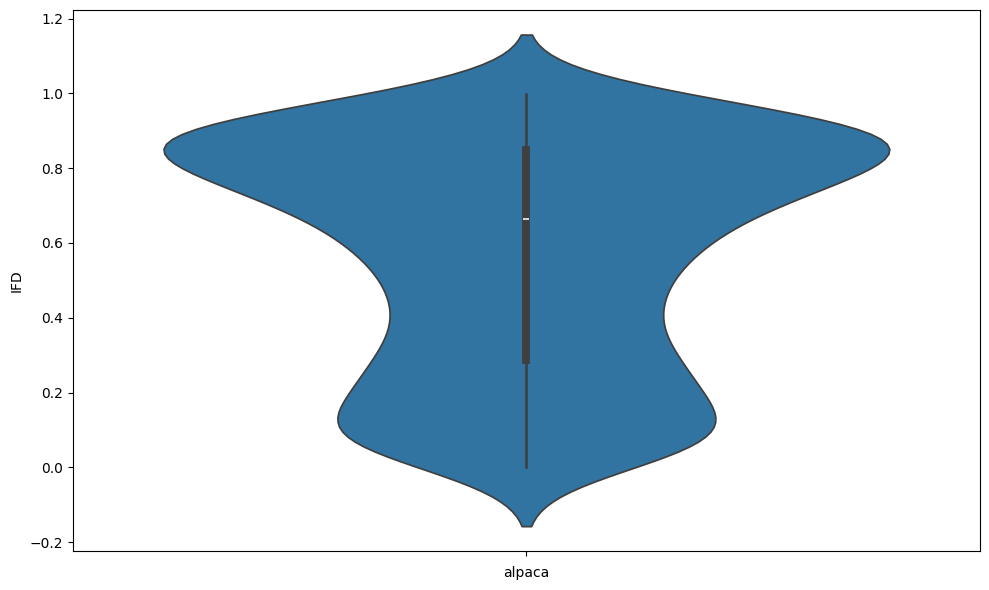

In [6]:
df = df[(df["ifd"] < 1) & (df["ifd"] > 0)]
plt.figure(figsize=(10, 6))
sns.violinplot(y=df["ifd"])
plt.xlabel("alpaca")
plt.ylabel("IFD")
plt.tight_layout()
plt.show()

In [7]:
sample_rate = 0.2
top_20_percent = df.nlargest(n=int(len(df) * sample_rate), columns="ifd")
print(top_20_percent["ifd"].describe())

count    176.000000
mean       0.923945
std        0.035517
min        0.869979
25%        0.892564
50%        0.921134
75%        0.951155
max        0.999762
Name: ifd, dtype: float64


In [8]:
print(top_20_percent["data"].iloc[0])

{'instruction': 'Create a question about the consequences of global warming.', 'input': '', 'output': 'What are the potential consequences of global warming?', 'metadata': {'ppl': [14.922894477844238, 14.919337272644043], 'loss': [2.7028965950012207, 2.702658176422119], 'ifd': 0.999761627665097}}
